# APERO Demos

The aim of these demos is to walk you through some of the key steps in the
data reduction using APERO.

## Prerequisites for exercises

- Python 3.9  (e.g. via [conda](https://docs.conda.io/en/latest/miniconda.html))
    ```
    conda create --name=apero-demo python=3.9
    conda activate apero-demo
    pip install -r requirements.txt
    ```


- DS9 ([download](https://sites.google.com/cfa.harvard.edu/saoimageds9))


- dfits and fitsort
  - python implementation: [download](https://astrom-tom.github.io/dfitspy/build/html/installation.html)
  - C implmentation: [download](https://github.com/granttremblay/eso_fits_tools)


- Download the file bundle: [download](https://www.astro.umontreal.ca/~artigau/apero_demo/apero_nirps_demo.tar)


## Exercise 4: Extraction, making the S1D

- Step 1: Find the e2dsff A file for Proxima
- Step 2: Find the associated blaze file using the e2dsff header
- Step 3: Get the wavelength solution from the e2dsff (header or ORDER_TABLE extension)
- Step 4: In python construct a 1D wavelength grid
- Step 5: In python calculate an S1D using the blaze and the flux


In [14]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from astropy import constants
from astropy.io import fits
from scipy.interpolate import InterpolatedUnivariateSpline as IUSpline
from tqdm import tqdm

In [15]:
# notebook only
%matplotlib inline

In [3]:
def get_magic_grid(wave0=965, wave1=1950, dv_grid=1000):
    """
    Make a "magic" wavelength grid for the 1D file

    the arithmetic is a but confusing here, you first find how many
    elements you have on your grid, then pass it to an exponential
    the first element is exactly wave0, the last element is NOT
    exactly wave1, but is very close and is set to get your exact
    step in velocity

    :param wave0: float, starting value in nm
    :param wave1: float, end value in nm
    :param dv_grid: float, the grid in m/s (default is 1000 m/s)

    :return: np.array, the 1D wavelength grid
    """
    len_magic = np.log(wave1 / wave0) * constants.c.value / dv_grid

    part1 = np.arange(int(len_magic)) / len_magic
    part2 = np.log(wave1 / wave0)
    # calculate the grid
    magic_grid = np.exp(part1 * part2) * wave0
    return magic_grid

In [4]:
def fits2wave(image, hdr):
    """
    Get the wave solution from the header using a filename
    """
    # size of the image
    nbypix, nbxpix = image.shape
    # get the keys with the wavelength polynomials
    wave_hdr = hdr['WAVE0*']
    # concatenate into a numpy array
    wave_poly = np.array([wave_hdr[i] for i in range(len(wave_hdr))])
    # get the number of orders
    nord = hdr['WAVEORDN']
    # get the per-order wavelength solution
    wave_poly = wave_poly.reshape(nord, len(wave_poly) // nord)
    # project polynomial coefficiels
    wavesol = np.zeros_like(image)
    # xpixel grid
    xpix = np.arange(nbxpix)
    # loop around orders
    for _order_num in range(nord):
        # calculate wave solution for this order
        owave = val_cheby(wave_poly[_order_num], xpix, domain=[0, nbxpix])
        # push into wave map
        wavesol[_order_num] = owave
    # return wave grid
    return wavesol


def val_cheby(coeffs, xvector, domain):
    """
    Using the output of fit_cheby calculate the fit to x  (i.e. y(x))
    where y(x) = T0(x) + T1(x) + ... Tn(x)

    :param coeffs: output from fit_cheby
    :param xvector: x value for the y values with fit
    :param domain: domain to be transformed to -1 -- 1. This is important to
    keep the components orthogonal. For SPIRou orders, the default is 0--4088.
    You *must* use the same domain when getting values with fit_cheby
    :return: corresponding y values to the x inputs
    """
    # transform to a -1 to 1 domain
    domain_cheby = 2 * (xvector - domain[0]) / (domain[1] - domain[0]) - 1
    # fit values using the domain and coefficients
    yvector = np.polynomial.chebyshev.chebval(domain_cheby, coeffs)
    # return y vector
    return yvector

In [17]:
# all relevant files
e2ds_file = 'NIRPS_2023-01-20T08_42_08_941_pp_e2dsff_A.fits'
wave_file = 'NIRPS_2022-11-25T12_00_56_233_pp_e2dsff_A_wavesol_ref_A.fits'


In [18]:
# get the wave grid
wavegrid = get_magic_grid()
# storage for the weights and flux array
weights = np.zeros_like(wavegrid)
flux_tmp = np.zeros_like(wavegrid)
# load the e2ds and blaze file
e2ds = fits.getdata(e2ds_file)
header = fits.getheader(e2ds_file)
blaze = fits.getdata(header['CDBBLAZE'])

In [19]:
# get the wavelength solution from the header
wavemap = fits2wave(e2ds, header)

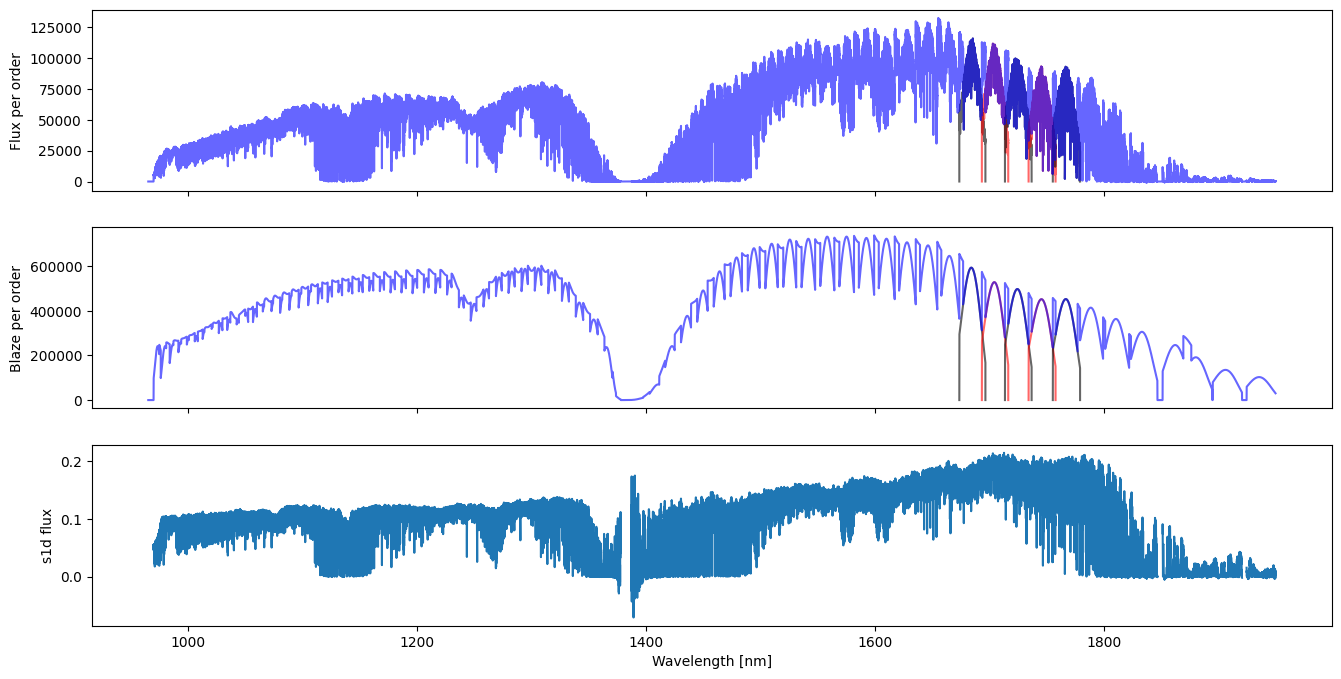

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex='all', figsize=(16, 8))
# loop around each order
for order_num in tqdm(range(e2ds.shape[0]), leave=False):
    # only keep non NaN points
    valid = np.isfinite(e2ds[order_num]) & np.isfinite(blaze[order_num])
    # spline only valid pixels, use ext=1 so that out-of-bound pixels
    # are set to 0.
    spl_flux = IUSpline(wavemap[order_num][valid], e2ds[order_num][valid],
                        ext=1, k=1)
    spl_blaze = IUSpline(wavemap[order_num][valid], blaze[order_num][valid],
                         ext=1, k=1)
    # be smart and only consider pixels in wavegrid that are
    # within the bounds of the order
    good = (wavegrid > np.min(wavemap[order_num]))
    good &= (wavegrid < np.max(wavemap[order_num]))
    # Add this orders contribution to the 1D vector
    flux_tmp[good] += spl_flux(wavegrid[good])
    weights[good] += spl_blaze(wavegrid[good])
    # plot the flux and blaze for a few orders only
    if (order_num > 62) and (order_num < 68):
        color = 'red' if order_num % 2 == 0 else 'black'

        ax[0].plot(wavegrid[good], spl_flux(wavegrid[good]), color=color,
                   alpha=0.6)
        ax[1].plot(wavegrid[good], spl_blaze(wavegrid[good]), color=color,
                   alpha=0.6)

# plot the 1D flux, weights and ratio between the two
ax[0].plot(wavegrid, flux_tmp, color='blue', alpha=0.6)
ax[1].plot(wavegrid, weights, color='blue', alpha=0.6)
with warnings.catch_warnings(record=True) as _:
    ax[2].plot(wavegrid, flux_tmp / weights)
ax[2].set(xlabel='Wavelength [nm]', ylabel='s1d flux')
ax[1].set(ylabel='Blaze per order')
ax[0].set(ylabel='Flux per order')
plt.show()